# Week 15

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import sys
import os
sys.path.append(os.path.abspath(os.path.join('..')))
from scipy.spatial import Delaunay
from scipy.optimize import minimize

from util.mesh.triangle.R2 import make_clockwise_2D, retrieve_boundary_angles_2D, retrieve_adjacent_vertices_with_boundary_vertex, retrieve_adjacent_vertices_with_vertex, retrieve_boundary_edges_related_vertices_2D
from util.mesh.triangle.algorithm.R2.embedding_Tutte import Tutte_embedding_2D
from util.mesh.triangle.common import retrieve_boundary_edges, retrieve_boundary_vertices
from util.mesh.triangle.algorithm.R2.mapping_poly_square import Liu_2017
from util.mesh.triangle.algorithm.R2.my_test import poly_square_tutte
from util.util import distance_euclidean

from util.pyvista_util import preprocess, postprocess

In [267]:
class poly_square_tutte:
    def __init__(self, vertices, faces, lambda1=1, lambda2=1, max_iter = 100):
        self.max_iter = max_iter
        self.v_num = vertices.shape[0]
        self.vertices = vertices
        self.solution = self.vertices.copy()
        self.faces = faces
        self.J = []
        self.b = []
        self.loss_history = []
        
        # Hyper parameters
        self.lambda1=lambda1
        self.lambda2=lambda2
        
        # Boundary realated "BE = boundary edges" and "BV = boundary vertices"
        self.BE_r_V = retrieve_boundary_edges(faces)
        self.BV_r_V = retrieve_boundary_vertices(faces)
        self.BV_r_BV = retrieve_adjacent_vertices_with_boundary_vertex(self.BV_r_V, self.BE_r_V)
        self.BE_r_BV = retrieve_boundary_edges_related_vertices_2D(self.BV_r_V, self.BE_r_V)
        self.BV_num = len(self.BV_r_V)
    
    def activation(self, angle):
        if angle < (np.pi/2):
            return np.power(np.cos(angle), 2) / angle
        else:
            return 0
        
    def objective(self, BV):
        BV = BV.reshape((self.BV_num,2))

        E_align = 0
        E_angle = 0
        
        for i, (v1, v2) in enumerate(self.BV_r_BV):
            edge1 = BV[v1] - BV[i]
            edge2 = BV[v2] - BV[i]
            
            L1 = np.linalg.norm(edge1)
            L2 = np.linalg.norm(edge2)
            
            cos_theta = np.dot(edge1, edge2) / (L1 * L2)
            if cos_theta > 0:
                angle = np.arccos(np.clip(cos_theta, -1.0, 1.0))
                E_angle += cos_theta / (angle)
                # sin
#                 sin_theta = np.linalg.norm(np.cross(edge1, edge2)) / (L1 * L2)
#                 E_angle += (1 / sin_theta - 1)
            
            E_align += L1*(np.sum(np.absolute(edge1/L1)) - 1) + L2*(np.sum(np.absolute(edge2/L2)) - 1)

        return self.lambda2*E_align + self.lambda1*E_angle
    
    def mapping(self):
        self.solution = Tutte_embedding_2D(self.vertices, self.faces, self.solution[self.BV_r_V])
        
        for face in self.faces:
            A, B, C = self.solution[face]
            A_, B_, C_ = self.vertices[face]
            
            before = np.column_stack([B_-A_,C_-A_])
            after = np.column_stack([B-A,C-A])
            J_ = after @ np.linalg.inv(before)
            b_ = J_ @ B_ - B
            self.J.append(J_)
            self.b.append(b_)
            
    
    def optimize_default(self):
        x0 = np.ravel(self.solution[self.BV_r_V])
        self.res = minimize(self.objective, x0, options = {'maxiter': self.max_iter}, method = "BFGS", callback=self.callback)
        self.solution[self.BV_r_V] = self.res.x.reshape((len(self.BV_r_V) , 2))
    
    def optimize(self, iter_num):
        for i in range(iter_num):
            self.optimize_one_round()
            print("Round ", i, " done!")
    
    def optimize_one_round(self):
        x0 = np.ravel(self.solution[self.BV_r_V])
        self.res = minimize(self.objective, x0, options = {'maxiter': 1}, method = "BFGS", callback=self.callback)
        self.solution[self.BV_r_V] = self.res.x.reshape((len(self.BV_r_V) , 2))
        
    def callback(self, x0):
        self.loss_history.append(self.objective(x0))
        
    def v_plt(self, show_origin=False, show_BV=False, show_vertices=False, show_inner_edges=False, save_dict='', show_boundary_v=False):
#         plt.triplot(self.vertices[:,0], self.vertices[:,1], self.faces, label='Original Mesh', color='blue')
        if show_inner_edges:
            plt.triplot(self.solution[:,0], self.solution[:,1], self.faces, color='skyblue')
        if show_vertices:
            plt.plot(self.vertices[:,0], self.vertices[:,1], 'o')
        if show_BV:
            BV = self.solution[self.BV_r_V]
            plt.plot(BV[:,0], BV[:,1], 'o', color="green")
        if show_origin:
            for edge in self.BE_r_V:
                plt.plot(self.vertices[np.array(edge), 0], self.vertices[np.array(edge), 1], 'g-')
            plt.plot(self.vertices[np.array(self.BE_r_V[0]), 0], self.vertices[np.array(self.BE_r_V[0]), 1],label='Boundary before mapping', color='green')
            if show_inner_edges:
                plt.triplot(self.vertices[:,0], self.vertices[:,1], self.faces, color='greenyellow')
        for edge in self.BE_r_V:
            plt.plot(self.solution[np.array(edge), 0], self.solution[np.array(edge), 1], 'b-')
        plt.plot(self.solution[np.array(self.BE_r_V[0]), 0], self.solution[np.array(self.BE_r_V[0]), 1], label='Boundary after mapping', color='blue')
        if show_boundary_v:
            plt.plot(self.solution[self.BV_r_V,0], self.solution[self.BV_r_V,1], 'o')
        plt.axis('equal')
        plt.legend()
        if save_dict:
            plt.savefig(save_dict, dpi=300)
        plt.show()
        
    def v_loss(self, save_dict=''):
        iterations = list(range(1, len(self.loss_history) + 1))
        plt.plot(iterations, self.loss_history, '-o', label='Loss Value', markersize=3)
        plt.title('Loss vs. Iterations')
        plt.xlabel('Iterations')
        plt.ylabel('Loss')
        if save_dict:
            plt.savefig(save_dict, dpi=300)
        plt.legend()
        plt.show()

In [268]:
# def compute_star_points(R):
#     outer_radians = np.deg2rad(72 * np.arange(5))
#     outer_x = R * np.cos(outer_radians)
#     outer_y = R * np.sin(outer_radians)
#     outer_points = np.column_stack((outer_x, outer_y))
    
#     r = R * np.sin(np.deg2rad(18)) / np.sin(np.deg2rad(36))
    
#     inner_radians = np.deg2rad(72 * np.arange(5) + 36)
#     inner_x = r * np.cos(inner_radians)
#     inner_y = r * np.sin(inner_radians)
#     inner_points = np.column_stack((inner_x, inner_y))
    
#     inner_tri= Delaunay(inner_points)
#     faces = inner_tri.simplices
#     vertices = np.vstack((inner_points, outer_points))    
#     face_temp = np.array([[4,5,0],[0,6,1],[1,7,2],[2,8,3],[3,9,4]])
#     faces = np.vstack((faces, face_temp))
    
#     return vertices, faces

# R = 1
# vertices, faces = compute_star_points(R)

# plt.triplot(vertices[:,0], vertices[:,1], faces)
# plt.axis('equal')
# plt.show()

# ===========================================================

In [269]:
poly = poly_square_tutte(vertices, faces, max_iter=100
                         , lambda1=10
#                          , initial=10
                        )

In [280]:
poly.optimize_default()

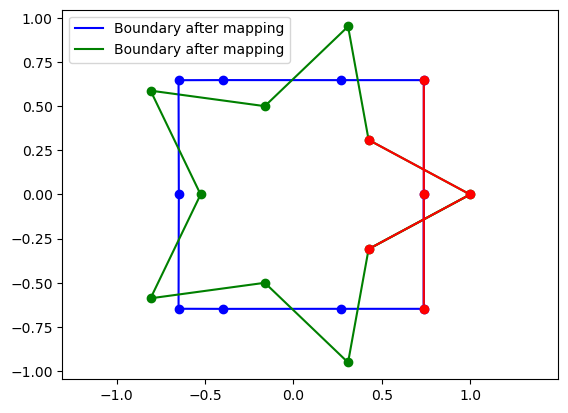

In [281]:
# plt.triplot(poly.solution[:,0], poly.solution[:,1], faces)
for edge in poly.BE_r_V:
    plt.plot(poly.solution[np.array(edge), 0], poly.solution[np.array(edge), 1], 'b-')
    plt.plot(poly.vertices[np.array(edge), 0], poly.vertices[np.array(edge), 1], 'g-')
plt.plot(poly.solution[np.array(poly.BE_r_V[0]), 0], poly.solution[np.array(poly.BE_r_V[0]), 1], label='Boundary after mapping', color='blue')
plt.plot(poly.vertices[np.array(poly.BE_r_V[0]), 0], poly.vertices[np.array(poly.BE_r_V[0]), 1], label='Boundary after mapping', color='green')

plt.plot(poly.solution[[4,5,0], 0], poly.solution[[4,5,0], 1], color='red')
plt.plot(poly.vertices[[4,5,0], 0], poly.vertices[[4,5,0], 1], color='red')

plt.plot(vertices[:,0], vertices[:,1], 'o', color="green")
plt.plot(poly.solution[:,0], poly.solution[:,1], 'o', color="blue")
plt.plot(poly.solution[[4,5,0], 0], poly.solution[[4,5,0], 1], 'o', color='red')
plt.plot(poly.vertices[[4,5,0], 0], poly.vertices[[4,5,0], 1], 'o', color='red')

plt.axis('equal')
plt.legend()
plt.savefig('./mesh/1problems/edge_collapse/Poly_Square_Map/cos_fix/converge_10', dpi=300)
plt.show()

In [198]:
poly.mapping()

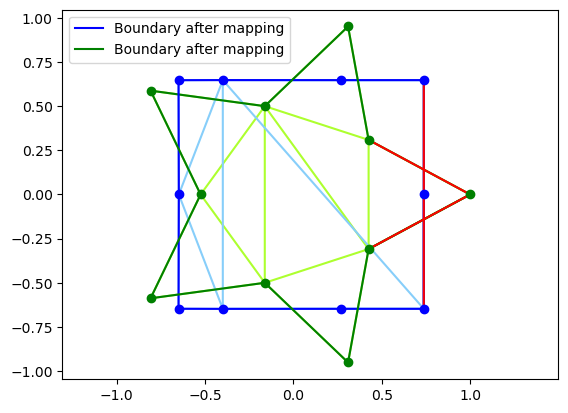

In [282]:
# plt.triplot(poly.solution[:,0], poly.solution[:,1], faces)
for edge in poly.BE_r_V:
    plt.plot(poly.solution[np.array(edge), 0], poly.solution[np.array(edge), 1], 'b-')
    plt.plot(poly.vertices[np.array(edge), 0], poly.vertices[np.array(edge), 1], 'g-')
plt.plot(poly.solution[np.array(poly.BE_r_V[0]), 0], poly.solution[np.array(poly.BE_r_V[0]), 1], label='Boundary after mapping', color='blue')
plt.plot(poly.vertices[np.array(poly.BE_r_V[0]), 0], poly.vertices[np.array(poly.BE_r_V[0]), 1], label='Boundary after mapping', color='green')

plt.plot(poly.solution[[4,5,0], 0], poly.solution[[4,5,0], 1], color='red')
plt.plot(poly.vertices[[4,5,0], 0], poly.vertices[[4,5,0], 1], color='red')

plt.plot(vertices[:,0], vertices[:,1], 'o', color="green")
plt.plot(poly.solution[:,0], poly.solution[:,1], 'o', color="blue")
# plt.plot(poly.solution[[4,5,0], 0], poly.solution[[4,5,0], 1], 'o', color='red')
# plt.plot(poly.vertices[[4,5,0], 0], poly.vertices[[4,5,0], 1], 'o', color='red')

plt.triplot(poly.vertices[:,0], poly.vertices[:,1], faces, color='greenyellow')
plt.triplot(poly.solution[:,0], poly.solution[:,1], faces, color='lightskyblue')

plt.axis('equal')
plt.legend()
plt.savefig('./mesh/1problems/edge_collapse/Poly_Square_Map/cos_fix/10/converge_10', dpi=300)
plt.show()

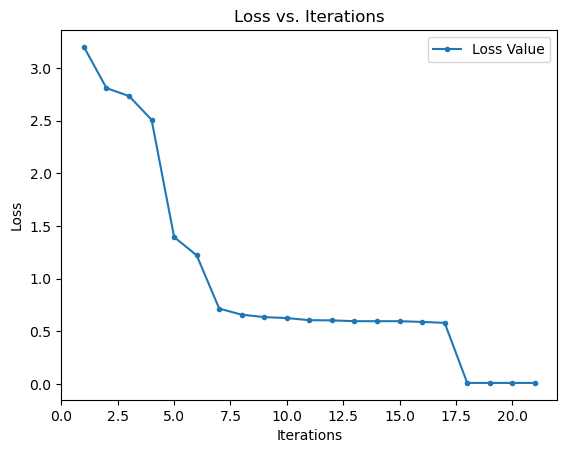

In [284]:
poly.v_loss(
    save_dict='./mesh/1problems/edge_collapse/Poly_Square_Map/cos_fix/10/loss_10.png'
)

# ============================================================

In [254]:
class Liu_2017:
    def __init__(self, vertices, faces, lambda_=5, max_iter = 30):
        self.max_iter = max_iter
        self.vertex_num = vertices.shape[0]
        self.vertices = vertices
        self.faces = faces
        self.lambda_=lambda_
        self.loss_history = []
        
        self.solution = self.vertices.copy()
        self.boundary_edges = retrieve_boundary_edges(faces)
        
    def loss(self, x):
        X = x.reshape((self.vertex_num, 2))
        
        # Boundary edges alignment
        EB = 0
        for edge in self.boundary_edges:
            A, B = X[edge[0]], X[edge[1]]
            EB += np.sum(np.absolute(B - A)) - distance_euclidean(A, B)
            
        # Distortion term
        ED = 0
        for face in self.faces:
            A, B, C = X[face[0]], X[face[1]], X[face[2]]
            A_, B_, C_ = self.vertices[face[0]], self.vertices[face[1]], self.vertices[face[2]]

            before = np.column_stack([B_-A_,C_-A_])
            after = np.column_stack([B-A,C-A])
            J = after @ np.linalg.inv(before)

            u, s, v = np.linalg.svd(J)
            s1, s2 = s[0], s[1]
            ED += np.exp(s1/s2 + s2/s1)
            
#         print(self.lambda_, EB, ED)
            
        return self.lambda_*EB+ED
    
    def optimize(self, num_iter):
        for i in range(num_iter):
            x0 = np.ravel(self.solution)
            self.res = minimize(self.loss, x0, options = {'maxiter': 1}, callback=self.callback)
            self.solution = self.res.x.reshape((self.vertex_num, 2))
    
    def optimize_one_round(self):
        x0 = np.ravel(self.solution)
        self.res = minimize(self.loss, x0, options = {'maxiter': 1}, callback=self.callback)
        self.solution = self.res.x.reshape((self.vertex_num, 2))
        
    def optimize_default(self):
        x0 = np.ravel(self.solution)
        self.res = minimize(self.loss, x0, options = {'maxiter': self.max_iter}, callback=self.callback)
        self.solution = self.res.x.reshape((self.vertex_num, 2))
        
    def callback(self, x0):
        self.loss_history.append(self.loss(x0))
        
    def visualize_initial(self, show_boundary = False):
        plt.plot(self.vertices[:,0], self.vertices[:,1], 'o', color='green')
        plt.triplot(self.vertices[:,0], self.vertices[:,1], self.faces, label='Original Mesh', color='orange')
        if show_boundary:
            for edge in self.boundary_edges:
                plt.plot(self.vertices[np.array(edge), 0], self.vertices[np.array(edge), 1], 'y-')
        plt.axis('equal')
        plt.legend()
#         plt.show()
        
    def visualize_solution(self, show_boundary = False):
        plt.plot(self.solution[:,0], self.solution[:,1], 'o', color='blue')
        plt.triplot(self.solution[:,0], self.solution[:,1], self.faces, label='Transformed Mesh', color='blue')
        if show_boundary:
            for edge in self.boundary_edges:
                plt.plot(self.solution[np.array(edge), 0], self.solution[np.array(edge), 1], 'r-')
        plt.axis('equal')
        plt.legend()
#         plt.show()
        
    def visualize(self):
        self.visualize_initial()
        self.visualize_solution()
        
    def v_loss(self, save_dict=''):
        iterations = list(range(1, len(self.loss_history) + 1))
        plt.plot(iterations, self.loss_history, '-o', label='Loss Value', markersize=3)
        plt.title('Loss vs. Iterations')
        plt.xlabel('Iterations')
        plt.ylabel('Loss')
        if save_dict:
            plt.savefig(save_dict, dpi=300)
        plt.legend()
        plt.show()

In [284]:
liu = Liu_2017(vertices, faces, max_iter=100)

In [285]:
liu.optimize_default()

In [286]:
liu.res

      fun: 59.175736646821555
 hess_inv: array([[0.24577878, 0.14343233, 0.24122141, 0.14532421, 0.23804664,
        0.14136769, 0.24088662, 0.13731253, 0.24540715, 0.13858215,
        0.25035246, 0.140861  , 0.24539375, 0.14877158, 0.23572769,
        0.14636758, 0.2357866 , 0.13687566, 0.24458879, 0.13337902],
       [0.14343233, 0.24118462, 0.13897669, 0.2429938 , 0.1358977 ,
        0.23910866, 0.13870148, 0.23516069, 0.14311213, 0.2364427 ,
        0.14792281, 0.23871327, 0.14301435, 0.24636971, 0.13360736,
        0.24398797, 0.13371506, 0.23470883, 0.14235208, 0.23133219],
       [0.24122141, 0.13897669, 0.23689846, 0.14078034, 0.23387095,
        0.13701139, 0.23658054, 0.13315855, 0.24087341, 0.13436772,
        0.24557751, 0.1365464 , 0.24085469, 0.14403948, 0.23165613,
        0.14177862, 0.23172808, 0.13274211, 0.24010948, 0.12940768],
       [0.14532421, 0.2429938 , 0.14078034, 0.24487416, 0.13762105,
        0.2409244 , 0.14045672, 0.23688431, 0.14496056, 0.23815679,
    

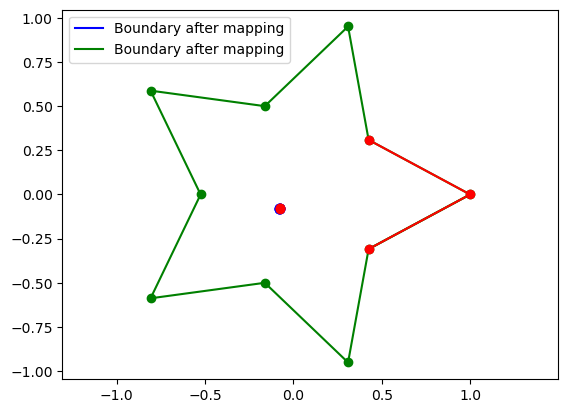

In [287]:
# plt.triplot(poly.solution[:,0], poly.solution[:,1], faces)
for edge in liu.boundary_edges:
    plt.plot(liu.solution[np.array(edge), 0], liu.solution[np.array(edge), 1], 'b-')
    plt.plot(liu.vertices[np.array(edge), 0], liu.vertices[np.array(edge), 1], 'g-')
plt.plot(liu.solution[np.array(liu.boundary_edges[0]), 0], liu.solution[np.array(liu.boundary_edges[0]), 1], label='Boundary after mapping', color='blue')
plt.plot(liu.vertices[np.array(liu.boundary_edges[0]), 0], liu.vertices[np.array(liu.boundary_edges[0]), 1], label='Boundary after mapping', color='green')

plt.plot(liu.solution[[4,5,0], 0], liu.solution[[4,5,0], 1], color='red')
plt.plot(liu.vertices[[4,5,0], 0], liu.vertices[[4,5,0], 1], color='red')

plt.plot(vertices[:,0], vertices[:,1], 'o', color="green")
plt.plot(liu.solution[:,0], liu.solution[:,1], 'o', color="blue")
plt.plot(liu.solution[[4,5,0], 0], liu.solution[[4,5,0], 1], 'o', color='red')
plt.plot(liu.vertices[[4,5,0], 0], liu.vertices[[4,5,0], 1], 'o', color='red')

plt.axis('equal')
plt.legend()
# plt.savefig('./mesh/1problems/edge_collapse/Liu_2017/example_Liu_2017_converge66_5', dpi=300)
plt.show()

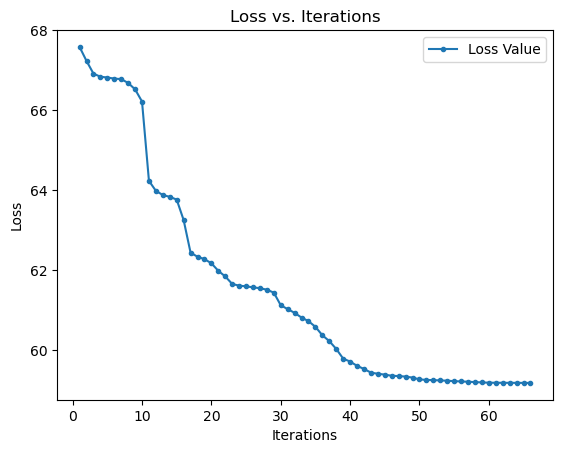

In [289]:
liu.v_loss(
#     save_dict='./mesh/1problems/edge_collapse/Liu_2017/loss_polysquare_01.png'
)

# ============================================================

In [292]:
class l1_norm_based:
    def __init__(self, vertices, faces, lambda_=1, max_iter = 100):
        self.max_iter = max_iter
        self.v_num = vertices.shape[0]
        self.vertices = vertices
        self.solution = self.vertices.copy()
        self.faces = faces
        self.J = []
        self.b = []
        self.loss_history = []
        
        # Hyper parameters
        self.lambda_=lambda_
        
        # Boundary realated "BE = boundary edges" and "BV = boundary vertices"
        self.BE_r_V = retrieve_boundary_edges(faces)
        self.BV_r_V = retrieve_boundary_vertices(faces)
        self.BV_r_BV = retrieve_adjacent_vertices_with_boundary_vertex(self.BV_r_V, self.BE_r_V)
        self.BE_r_BV = retrieve_boundary_edges_related_vertices_2D(self.BV_r_V, self.BE_r_V)
        self.BV_num = len(self.BV_r_V)
    
    def activation(self, angle):
        if angle < (np.pi/2):
            return np.power(np.cos(angle), 2) / angle
        else:
            return 0
        
    def objective(self, BV):
        BV = BV.reshape((self.BV_num,2))

        E_align = 0
        E_angle = 0
        
        for i, (v1, v2) in enumerate(self.BV_r_BV):
            edge1 = BV[v1] - BV[i]
            edge2 = BV[v2] - BV[i]
            
            L1 = np.linalg.norm(edge1)
            L2 = np.linalg.norm(edge2)
            
            cos_theta = np.dot(edge1, edge2) / (L1 * L2)
#             if cos_theta > 0:
#                 angle = np.arccos(np.clip(cos_theta, -1.0, 1.0))
#                 E_angle += self.activation(angle)
            
            E_align += L1*(np.sum(np.absolute(edge1/L1)) - 1) + L2*(np.sum(np.absolute(edge2/L2)) - 1)

        return E_angle + self.lambda_*E_align
    
    def mapping(self):
        self.solution = Tutte_embedding_2D(self.vertices, self.faces, self.solution[self.BV_r_V])
        
        for face in self.faces:
            A, B, C = self.solution[face]
            A_, B_, C_ = self.vertices[face]
            
            before = np.column_stack([B_-A_,C_-A_])
            after = np.column_stack([B-A,C-A])
            J_ = after @ np.linalg.inv(before)
            b_ = J_ @ B_ - B
            self.J.append(J_)
            self.b.append(b_)
            
    
    def optimize_default(self):
        x0 = np.ravel(self.solution[self.BV_r_V])
        self.res = minimize(self.objective, x0, options = {'maxiter': self.max_iter}, method = "BFGS", callback=self.callback)
        self.solution[self.BV_r_V] = self.res.x.reshape((len(self.BV_r_V) , 2))
    
    def optimize(self, iter_num):
        for i in range(iter_num):
            self.optimize_one_round()
            print("Round ", i, " done!")
    
    def optimize_one_round(self):
        x0 = np.ravel(self.solution[self.BV_r_V])
        self.res = minimize(self.objective, x0, options = {'maxiter': 1}, method = "BFGS", callback=self.callback)
        self.solution[self.BV_r_V] = self.res.x.reshape((len(self.BV_r_V) , 2))
        
    def callback(self, x0):
        self.loss_history.append(self.objective(x0))
        
    def v_plt(self, show_origin=False, show_BV=False, show_vertices=False, show_inner_edges=False, save_dict='', show_boundary_v=False):
#         plt.triplot(self.vertices[:,0], self.vertices[:,1], self.faces, label='Original Mesh', color='blue')
        if show_inner_edges:
            plt.triplot(self.solution[:,0], self.solution[:,1], self.faces, color='skyblue')
        if show_vertices:
            plt.plot(self.vertices[:,0], self.vertices[:,1], 'o')
        if show_BV:
            BV = self.solution[self.BV_r_V]
            plt.plot(BV[:,0], BV[:,1], 'o', color="green")
        if show_origin:
            for edge in self.BE_r_V:
                plt.plot(self.vertices[np.array(edge), 0], self.vertices[np.array(edge), 1], 'g-')
            plt.plot(self.vertices[np.array(self.BE_r_V[0]), 0], self.vertices[np.array(self.BE_r_V[0]), 1],label='Boundary before mapping', color='green')
            if show_inner_edges:
                plt.triplot(self.vertices[:,0], self.vertices[:,1], self.faces, color='greenyellow')
        for edge in self.BE_r_V:
            plt.plot(self.solution[np.array(edge), 0], self.solution[np.array(edge), 1], 'b-')
        plt.plot(self.solution[np.array(self.BE_r_V[0]), 0], self.solution[np.array(self.BE_r_V[0]), 1], label='Boundary after mapping', color='blue')
        if show_boundary_v:
            plt.plot(self.solution[self.BV_r_V,0], self.solution[self.BV_r_V,1], 'o')
        plt.axis('equal')
        plt.legend()
        if save_dict:
            plt.savefig(save_dict, dpi=300)
        plt.show()
        
    def v_loss(self, save_dict=''):
        iterations = list(range(1, len(self.loss_history) + 1))
        plt.plot(iterations, self.loss_history, '-o', label='Loss Value', markersize=3)
        plt.title('Loss vs. Iterations')
        plt.xlabel('Iterations')
        plt.ylabel('Loss')
        if save_dict:
            plt.savefig(save_dict, dpi=300)
        plt.legend()
        plt.show()

In [297]:
l1 = l1_norm_based(vertices, faces, max_iter=100, lambda_=0.1)

In [310]:
# l1.optimize_default()
l1.optimize(100)

Round  0  done!
Round  1  done!
Round  2  done!
Round  3  done!
Round  4  done!
Round  5  done!
Round  6  done!
Round  7  done!
Round  8  done!
Round  9  done!
Round  10  done!
Round  11  done!
Round  12  done!
Round  13  done!
Round  14  done!
Round  15  done!
Round  16  done!
Round  17  done!
Round  18  done!
Round  19  done!
Round  20  done!
Round  21  done!
Round  22  done!
Round  23  done!
Round  24  done!
Round  25  done!
Round  26  done!
Round  27  done!
Round  28  done!
Round  29  done!
Round  30  done!
Round  31  done!
Round  32  done!
Round  33  done!
Round  34  done!
Round  35  done!
Round  36  done!
Round  37  done!
Round  38  done!
Round  39  done!
Round  40  done!
Round  41  done!
Round  42  done!
Round  43  done!
Round  44  done!
Round  45  done!
Round  46  done!
Round  47  done!
Round  48  done!
Round  49  done!
Round  50  done!
Round  51  done!
Round  52  done!
Round  53  done!
Round  54  done!
Round  55  done!
Round  56  done!
Round  57  done!
Round  58  done!
Round  

In [316]:
l1.mapping()

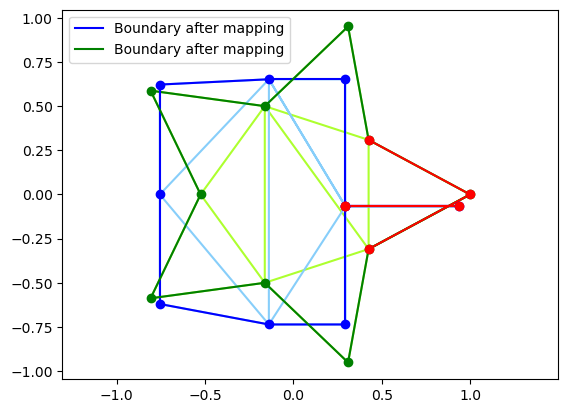

In [319]:
# plt.triplot(poly.solution[:,0], poly.solution[:,1], faces)
for edge in l1.BE_r_V:
    plt.plot(l1.solution[np.array(edge), 0], l1.solution[np.array(edge), 1], 'b-')
    plt.plot(l1.vertices[np.array(edge), 0], l1.vertices[np.array(edge), 1], 'g-')
plt.plot(l1.solution[np.array(l1.BE_r_V[0]), 0], l1.solution[np.array(l1.BE_r_V[0]), 1], label='Boundary after mapping', color='blue')
plt.plot(l1.vertices[np.array(l1.BE_r_V[0]), 0], l1.vertices[np.array(l1.BE_r_V[0]), 1], label='Boundary after mapping', color='green')

plt.plot(l1.solution[[4,5,0], 0], l1.solution[[4,5,0], 1], color='red')
plt.plot(l1.vertices[[4,5,0], 0], l1.vertices[[4,5,0], 1], color='red')

plt.plot(vertices[:,0], vertices[:,1], 'o', color="green")
plt.plot(l1.solution[:,0], l1.solution[:,1], 'o', color="blue")
plt.plot(l1.solution[[4,5,0], 0], l1.solution[[4,5,0], 1], 'o', color='red')
plt.plot(l1.vertices[[4,5,0], 0], l1.vertices[[4,5,0], 1], 'o', color='red')

plt.triplot(l1.vertices[:,0], l1.vertices[:,1], faces, color='greenyellow')
plt.triplot(l1.solution[:,0], l1.solution[:,1], faces, color='lightskyblue')

plt.axis('equal')
plt.legend()
plt.savefig('./mesh/1problems/edge_collapse/l1_norm/example_l1_converge_01', dpi=300)
plt.show()

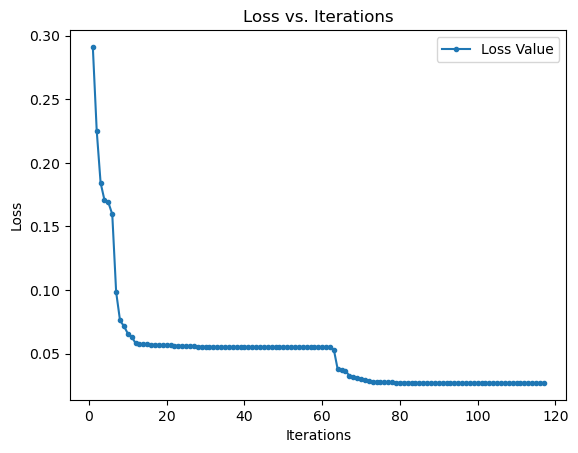

In [322]:
l1.v_loss(
    save_dict='./mesh/1problems/edge_collapse/l1_norm/loss_l1_converge_01'
)

In [ ]:
l1.mapping()

# ============================================================

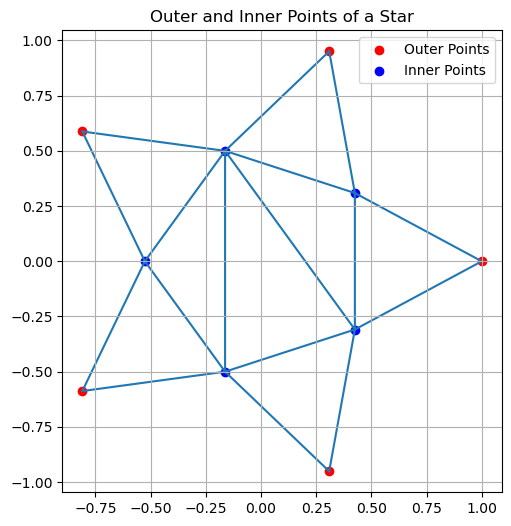

In [159]:
def compute_star_points(R):
    outer_radians = np.deg2rad(72 * np.arange(5))  # 72° 转化为弧度
    outer_x = R * np.cos(outer_radians)
    outer_y = R * np.sin(outer_radians)
    outer_points = np.column_stack((outer_x, outer_y))
    
    r = R * np.sin(np.deg2rad(18)) / np.sin(np.deg2rad(36))
    
    inner_radians = np.deg2rad(72 * np.arange(5) + 36)  # 72°*k + 36° 转化为弧度
    inner_x = r * np.cos(inner_radians)
    inner_y = r * np.sin(inner_radians)
    inner_points = np.column_stack((inner_x, inner_y))
    
    inner_tri= Delaunay(inner_points)
    faces = inner_tri.simplices
    vertices = np.vstack((inner_points, outer_points))    
    face_temp = np.array([[4,5,0],[0,6,1],[1,7,2],[2,8,3],[3,9,4]])
    faces = np.vstack((faces, face_temp))
    
    return vertices, faces

R = 1
outer_points, inner_points = compute_star_points(R)

plt.figure(figsize=(6,6))
plt.scatter(outer_points[:, 0], outer_points[:, 1], color='red', label='Outer Points')
plt.scatter(inner_points[:, 0], inner_points[:, 1], color='blue', label='Inner Points')
plt.triplot(vertices1[:,0], vertices1[:,1], faces1)
# plt.scatter(vertices1[5,0], vertices1[5,1])
# plt.scatter(vertices1[0,0], vertices1[0,1])

plt.gca().set_aspect('equal')
plt.title("Outer and Inner Points of a Star")
plt.legend()
plt.grid(True)
plt.show()


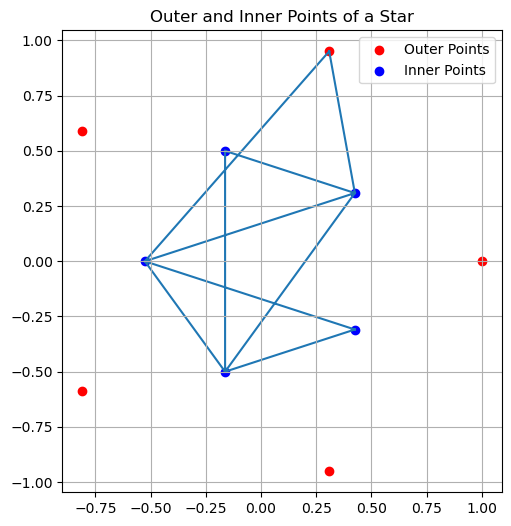

In [168]:
plt.figure(figsize=(6,6))
plt.scatter(outer_points[:, 0], outer_points[:, 1], color='red', label='Outer Points')
plt.scatter(inner_points[:, 0], inner_points[:, 1], color='blue', label='Inner Points')
plt.triplot(vertices[:,0], vertices[:,1], faces)
# plt.scatter(vertices1[5,0], vertices1[5,1])
# plt.scatter(vertices1[0,0], vertices1[0,1])

plt.gca().set_aspect('equal')
plt.title("Outer and Inner Points of a Star")
plt.legend()
plt.grid(True)
plt.show()


In [162]:
inner_tri= Delaunay(inner_points)
faces1 = inner_tri.simplices

In [163]:
vertices1 = np.vstack((inner_points, outer_points))

In [164]:
vertices1

array([[ 4.25325404e-01,  3.09016994e-01],
       [-1.62459848e-01,  5.00000000e-01],
       [-5.25731112e-01,  6.43834924e-17],
       [-1.62459848e-01, -5.00000000e-01],
       [ 4.25325404e-01, -3.09016994e-01],
       [ 1.00000000e+00,  0.00000000e+00],
       [ 3.09016994e-01,  9.51056516e-01],
       [-8.09016994e-01,  5.87785252e-01],
       [-8.09016994e-01, -5.87785252e-01],
       [ 3.09016994e-01, -9.51056516e-01]])

In [165]:
face_temp = np.array([[4,5,0],[0,6,1],[1,7,2],[2,8,3],[3,9,4]])

In [166]:
faces1 = np.vstack((faces1, face_temp))

In [169]:
vertices = vertices1
faces = faces1

In [281]:
def compute_star_points(R):
    outer_radians = np.deg2rad(72 * np.arange(5))
    outer_x = R * np.cos(outer_radians)
    outer_y = R * np.sin(outer_radians)
    outer_points = np.column_stack((outer_x, outer_y))
    
    r = R * np.sin(np.deg2rad(18)) / np.sin(np.deg2rad(36))
    
    inner_radians = np.deg2rad(72 * np.arange(5) + 36)
    inner_x = r * np.cos(inner_radians)
    inner_y = r * np.sin(inner_radians)
    inner_points = np.column_stack((inner_x, inner_y))
    
    inner_tri= Delaunay(inner_points)
    faces = inner_tri.simplices
    vertices = np.vstack((inner_points, outer_points))    
    face_temp = np.array([[4,5,0],[0,6,1],[1,7,2],[2,8,3],[3,9,4]])
    faces = np.vstack((faces, face_temp))
    
    return vertices, faces

In [283]:
R = 1
vertices2, faces2 = compute_star_points(R)

plt.triplot(vertices[:,0], vertices[:,1], faces)
plt.gca().set_aspect('equal')
plt.show()

$$
min f(V) = V_2 + V_3 - 2*V_1 + ||V_2 - V_1||_1 + ||V_3 - V_1||_1 \\
s.t. \cos(\theta) < 0 \\
cos(\theta) = \frac{(V_2 - V_1)\dot(V_3-V_1)}{||V_2 - V_1||_2||V_3 - V_1||_2}
$$

要求函数 \( f(V) \) 对 \( V_1 \) 的偏导数，我们首先需要考虑绝对值函数的导数。绝对值函数的导数依赖于其内部的值：

$$\frac{d}{dx} |x| = \begin{cases} 
1, & \text{if } x > 0 \\
-1, & \text{if } x < 0 \\
\text{undefined}, & \text{if } x = 0 
\end{cases} $$

现在考虑 \( f(V) \) 中涉及 \( V_1 \) 的项，有：

$$ -2V_1 + |V_2 - V_1| + |V_3 - V_1| $$

我们可以分别考虑 \( V_2 - V_1 \) 和 \( V_3 - V_1 \) 的符号来求偏导数。

1. 对于 \( |V_2 - V_1| \)：

偏导数是：

$$ \frac{\partial}{\partial V_1} |V_2 - V_1| = \begin{cases} 
-1, & \text{if } V_2 > V_1 \\
1, & \text{if } V_2 < V_1 \\
\text{undefined}, & \text{if } V_2 = V_1 
\end{cases} $$

2. 对于 \( |V_3 - V_1| \)：

偏导数是：

$$ \frac{\partial}{\partial V_1} |V_3 - V_1| = \begin{cases} 
-1, & \text{if } V_3 > V_1 \\
1, & \text{if } V_3 < V_1 \\
\text{undefined}, & \text{if } V_3 = V_1 
\end{cases} $$

现在，我们可以组合所有这些项来得到 \( f(V) \) 对 \( V_1 \) 的偏导数：

$$ \frac{\partial f(V)}{\partial V_1} = -2 + \frac{\partial}{\partial V_1} |V_2 - V_1| + \frac{\partial}{\partial V_1} |V_3 - V_1| $$

根据之前的分析，这个偏导数的值会依赖于 \( V_1, V_2, \) 和 \( V_3 \) 之间的相对大小。

In [2]:
import pyvista as pv

In [9]:
mesh = pv.read('./mesh/1problems/star.ply')

In [12]:
mesh.plot(show_edges =True)

Widget(value="<iframe src='http://localhost:56642/index.html?ui=P_0x21afcaa2490_2&reconnect=auto' style='width…